# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [13]:
# Update the PATH to include the user installation directory.
# import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [14]:
# Install requirements
# !python -m pip install -r requirements.txt

## Imports

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [17]:
# Define transforms
## YOUR CODE HERE ##
# MNIST mean = 0.1307, MNIST std = 0.3081
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.1307],[0.3081])])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.1307],[0.3081])])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = datasets.MNIST('..\data', download=True, train=True, transform=train_transform)

# Split training set into training and validation sets
generator = torch.Generator().manual_seed(42)
train_set_final, validate_set = torch.utils.data.random_split(train_set, [0.7, 0.3], generator=generator)

batch_size = 20
if(torch.cuda.is_available()):
    num_workers = 4
else:
    num_workers = 2

train_loader = torch.utils.data.DataLoader(train_set_final, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validate_set, batch_size=batch_size, num_workers=num_workers)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_set = datasets.MNIST('..\data', download=True, train=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Rotation, and horizontal and vertical flips are used as transforms to capture the different possible orientations for handwritten digits.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [18]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


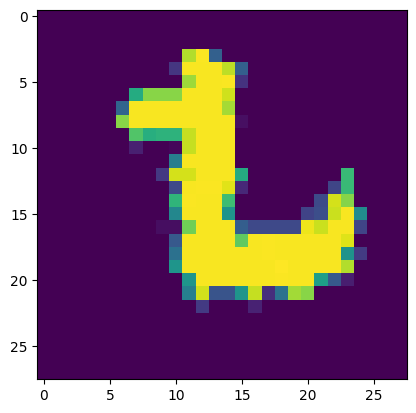

7


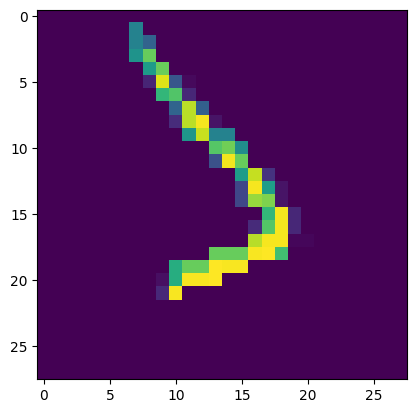

3


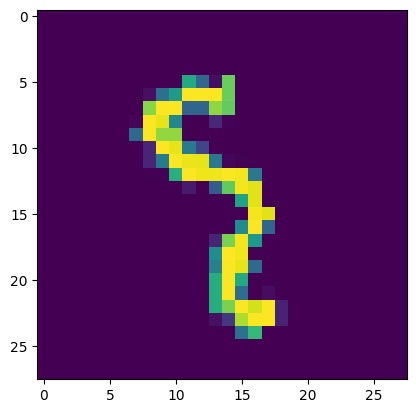

2


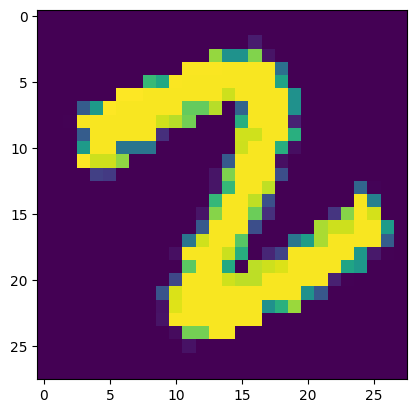

1


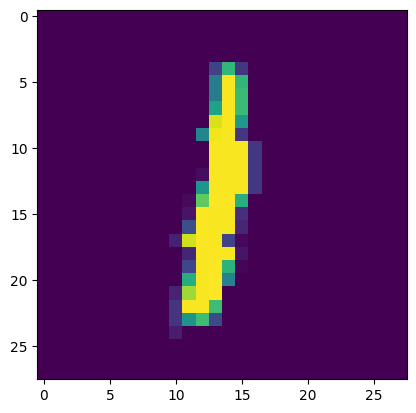

In [33]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)
images, labels = next(iter(train_loader))

7


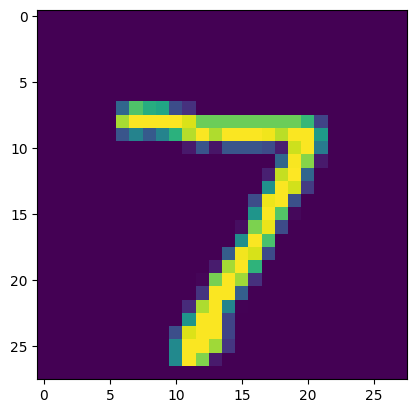

2


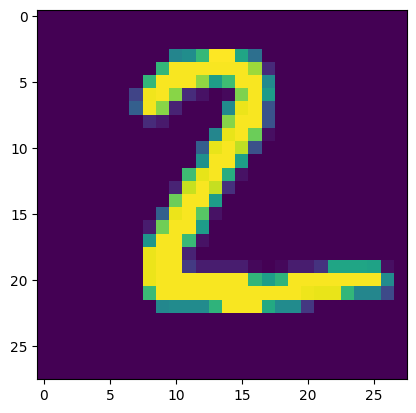

1


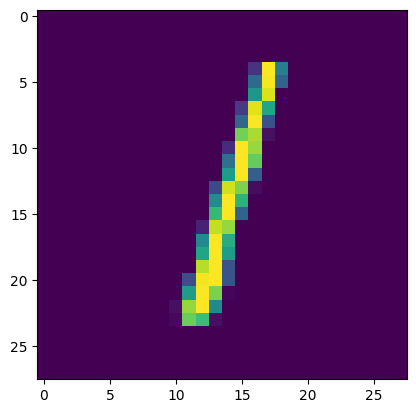

0


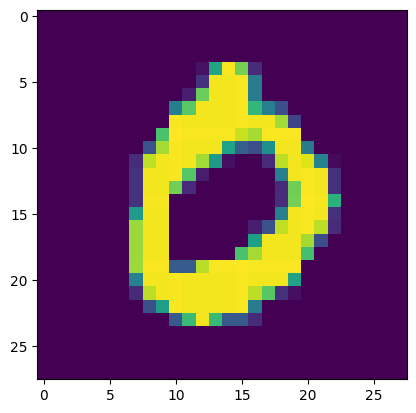

4


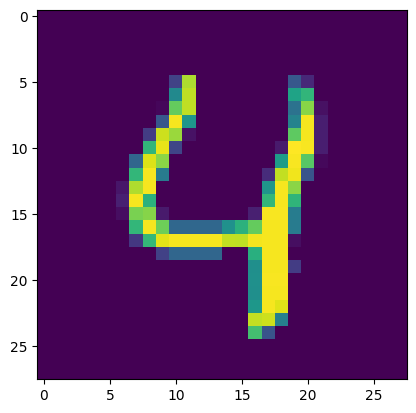

In [34]:
show5(test_loader)
images, labels = next(iter(test_loader))

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [21]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.activation = F.relu
        self.dropout = nn.Dropout2d(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(32*7*7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.dropout(self.activation(self.pool(self.conv1(x))))
        x = self.dropout(self.activation(self.pool(self.conv2(x))))

        x = x.view(x.shape[0], -1) # Flatten input tensor
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        x = self.activation(self.fc3(x)) # Output: No dropout here
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [22]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if it's available
model = Classifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [23]:
## YOUR CODE HERE ##
def train_model(optimizer,epochs):
  train_loss_epoch = []
  val_loss_epoch = []
  val_accuracy_epoch = []
  for epoch in range(epochs):
      running_train_loss = 0
      for train_images, train_labels in train_loader:
          train_images, train_labels = train_images.to(device), train_labels.to(device)
          optimizer.zero_grad()
          output_images = model(train_images)
          train_loss = criterion(output_images, train_labels)
          train_loss.backward()
          optimizer.step()
          running_train_loss += train_loss.item()

      train_loss_epoch.append(running_train_loss/len(train_loader))
      print(f'Epoch {epoch+1} / {epochs}...training finished. Training loss = {running_train_loss/len(train_loader):.5f}')

      model.eval()
      with torch.no_grad():
          running_val_loss = 0
          running_val_accuracy = 0
          for test_images, test_labels in validate_loader:
              test_images, test_labels = test_images.to(device), test_labels.to(device)
              output_images = model(test_images)
              test_loss = criterion(output_images, test_labels)
              _, preds = torch.max(output_images.data, 1)
              check = (preds == test_labels)
              running_val_accuracy += check.sum().div(len(check))
              running_val_loss += test_loss.item()

          val_loss_epoch.append(running_val_loss/len(validate_loader))
          val_accuracy_epoch.append(running_val_accuracy/len(validate_loader))
          print(f'Epoch {epoch+1} / {epochs}. Validation loss = {running_val_loss/len(validate_loader):.5f}. Validation accuracy = {running_val_accuracy/len(validate_loader):.5f}')
      model.train()

  return train_loss_epoch, val_loss_epoch, val_accuracy_epoch

In [24]:
epochs = 50
train_loss_epoch, val_loss_epoch, val_accuracy_epoch = train_model(optimizer,epochs)

Epoch 1 / 50...training finished. Training loss = 1.19544
Epoch 1 / 50. Validation loss = 0.65523. Validation accuracy = 0.77950
Epoch 2 / 50...training finished. Training loss = 0.80167
Epoch 2 / 50. Validation loss = 0.52185. Validation accuracy = 0.82350
Epoch 3 / 50...training finished. Training loss = 0.69014
Epoch 3 / 50. Validation loss = 0.46690. Validation accuracy = 0.85639
Epoch 4 / 50...training finished. Training loss = 0.61574
Epoch 4 / 50. Validation loss = 0.37364. Validation accuracy = 0.88017
Epoch 5 / 50...training finished. Training loss = 0.56809
Epoch 5 / 50. Validation loss = 0.33246. Validation accuracy = 0.89656
Epoch 6 / 50...training finished. Training loss = 0.53477
Epoch 6 / 50. Validation loss = 0.31388. Validation accuracy = 0.90383
Epoch 7 / 50...training finished. Training loss = 0.51190
Epoch 7 / 50. Validation loss = 0.29705. Validation accuracy = 0.90789
Epoch 8 / 50...training finished. Training loss = 0.48822
Epoch 8 / 50. Validation loss = 0.28382

Plot the training loss (and validation loss/accuracy, if recorded).

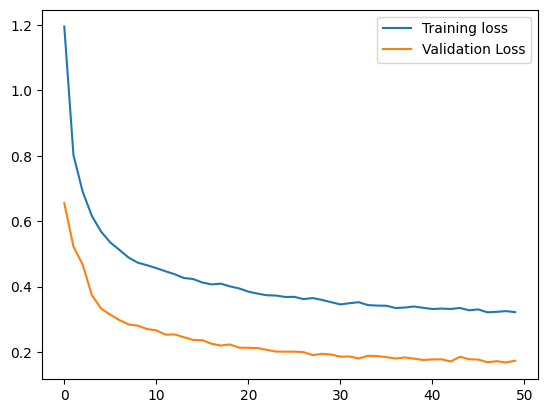

In [25]:
## YOUR CODE HERE ##
plt.plot(train_loss_epoch, label='Training loss')
plt.plot(val_loss_epoch, label="Validation Loss")
plt.legend()
plt.show()

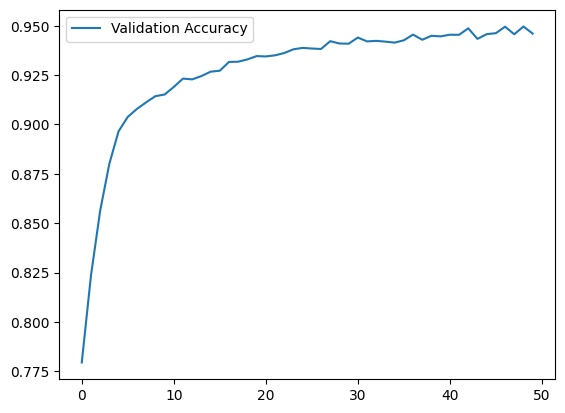

In [26]:
val_accuracy_epoch = np.array([x.item() for x in val_accuracy_epoch])
plt.plot(val_accuracy_epoch, label="Validation Accuracy")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [27]:
## YOUR CODE HERE ##
def test_model():
  test_accuracy = 0
  model.eval()
  with torch.no_grad():
      for test_images, test_labels in test_loader:
          test_images, test_labels = test_images.to(device), test_labels.to(device)
          output_images = model(test_images)
          _, preds = torch.max(output_images.data, 1)
          check = (preds == test_labels)
          test_accuracy += check.sum().div(len(check))

  test_accuracy = test_accuracy / len(test_loader)
  print(f"Test accuracy: {test_accuracy:.5f}")
  model.train()
  return test_accuracy

In [28]:
test_accuracy = test_model()

Test accuracy: 0.96270


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [29]:
## YOUR CODE HERE ##
learn_rate_list = [0.0001, 0.0005, 0.001, 0.005]
epoch_list = [100, 100, 50, 50]
test_accuracy_list = []
test_accuracy_prev = test_accuracy # save the value of test accuracy for lr = 0.001

for lr,epochs in zip(learn_rate_list, epoch_list):
  if(lr == 0.001):
    test_accuracy_list.append(test_accuracy_prev)
  else:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss_epoch, val_loss_epoch, val_accuracy_epoch = train_model(optimizer,epochs)
    test_accuracy = test_model()
    test_accuracy_list.append(test_accuracy)

Epoch 1 / 100...training finished. Training loss = 0.31001
Epoch 1 / 100. Validation loss = 0.16003. Validation accuracy = 0.94956
Epoch 2 / 100...training finished. Training loss = 0.29764
Epoch 2 / 100. Validation loss = 0.15958. Validation accuracy = 0.95012
Epoch 3 / 100...training finished. Training loss = 0.28967
Epoch 3 / 100. Validation loss = 0.15609. Validation accuracy = 0.95178
Epoch 4 / 100...training finished. Training loss = 0.29299
Epoch 4 / 100. Validation loss = 0.15284. Validation accuracy = 0.95206
Epoch 5 / 100...training finished. Training loss = 0.29041
Epoch 5 / 100. Validation loss = 0.15237. Validation accuracy = 0.95256
Epoch 6 / 100...training finished. Training loss = 0.28817
Epoch 6 / 100. Validation loss = 0.15782. Validation accuracy = 0.95100
Epoch 7 / 100...training finished. Training loss = 0.29097
Epoch 7 / 100. Validation loss = 0.15724. Validation accuracy = 0.95056
Epoch 8 / 100...training finished. Training loss = 0.28588
Epoch 8 / 100. Validatio

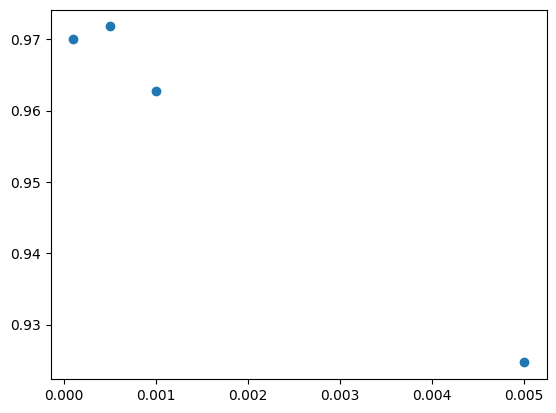

In [30]:
test_accuracy_list = np.array([x.item() for x in test_accuracy_list])
plt.scatter(learn_rate_list, test_accuracy_list)
plt.show()

Learning rate = 0.0005 achieves the highest test accuracy.

## Saving your model
Using `torch.save`, save your model for future loading.

In [32]:
## YOUR CODE HERE ##
best_model = {'input_size': 784, 'output_size': 10, 'state_dict': model.state_dict()}
torch.save(best_model, 'best_model_CNN.pth')